In [1]:
import geopandas as gpd

# Define the path to the shapefile
shapefile_path = "/Users/kasirajan/Documents/ACF/Modeled Surfaces/Data/Shapefile/India%3A_Village_Boundary_2021/India%3A_Village_Boundary_2021.shp"

# Read the shapefile using geopandas
shapefile = gpd.read_file(shapefile_path)

# Print the column names
print(shapefile.columns)

Index(['premiumdat', 'tru', 'no_hh', 'tot_p', 'avghhsz_cy', 'objectid', 'id',
       'name', 'subdistric', 'district', 'state', 'country', 'censusname',
       'villagenam', 'lgd_villag', 'lgd_vill_1', 'lgd_subdis', 'lgd_distri',
       'lgd_statec', 'censuscode', 'censusco_1', 'censusco_2', 'level',
       'st_areasha', 'st_lengths', 'geometry'],
      dtype='object')


In [23]:
import rasterio

# Define the path to the raster file
raster_file = "/Users/kasirajan/Documents/ACF/Modeled Surfaces/Data/Raster/IA2020DHS_AHTOBCMANY_MS_v01/IA2020DHS_AHTOBCMANY_MS_CI_v01.tif"

# Open the raster file
with rasterio.open(raster_file) as src:
    # Get the metadata of the raster
    meta = src.meta

# Print the metadata
print(meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.3999999521443642e+38, 'width': 702, 'height': 690, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.04166665, 0.0, 68.1665674,
       0.0, -0.041666649999999986, 35.4999618)}


In [24]:
import rasterio
import geopandas as gpd

# Load the shapefile
villages = gpd.read_file('/Users/kasirajan/Documents/ACF/Modeled Surfaces/Data/Shapefile/India%3A_Village_Boundary_2021/India%3A_Village_Boundary_2021.shp')

# Load the raster file
raster = rasterio.open('/Users/kasirajan/Documents/ACF/Modeled Surfaces/Data/Raster/IA2020DHS_AHTOBCMANY_MS_v01/IA2020DHS_AHTOBCMANY_MS_CI_v01.tif')


In [25]:
print(villages.crs)
print(raster.crs)
from rasterstats import zonal_stats

stats = zonal_stats(villages, '/Users/kasirajan/Documents/ACF/Modeled Surfaces/Data/Raster/IA2020DHS_AHTOBCMANY_MS_v01/IA2020DHS_AHTOBCMANY_MS_CI_v01.tif', stats="mean", nodata=raster.nodata)


EPSG:4326
EPSG:4326


In [5]:
pip install rasterstats


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [26]:
import pandas as pd

# Convert the list of dictionaries to a DataFrame
stats_df = pd.DataFrame(stats)

# Merge the statistics with the original shapefile
villages_with_stats = pd.concat([villages, stats_df], axis=1)


In [27]:
villages_with_stats.to_file('/Users/kasirajan/Documents/ACF/Modeled Surfaces/Output/NHS20_AH_TOBC_Village_Boundary_2021.shp')


In [28]:
muzaffarnagar_data = villages_with_stats[
    (villages_with_stats['district'] == 'Muzaffarnagar') & 
    (villages_with_stats['state'] == 'Uttar Pradesh')
]


In [29]:
import folium

# Create a base map centered around Muzaffarnagar
m = folium.Map(location=[29.4739, 77.7041], zoom_start=10)

# Add the village data to the map
folium.Choropleth(
    geo_data=muzaffarnagar_data,
    data=muzaffarnagar_data,
    columns=['id', 'mean'],  # Assuming 'id' is a unique identifier for each village; replace if different
    key_on='feature.properties.id',
    fill_color='YlGn',
    legend_name='Mean Raster Value'
).add_to(m)

# Display the map
m


count    147.000000
mean       0.117151
std        0.020518
min        0.084235
25%        0.099673
50%        0.115639
75%        0.135617
max        0.162604
Name: mean, dtype: float64


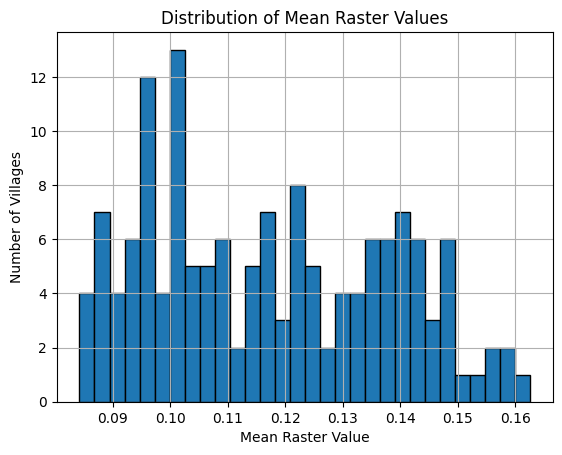

In [30]:
import matplotlib.pyplot as plt

# Descriptive statistics
print(muzaffarnagar_data['mean'].describe())

# Histogram
muzaffarnagar_data['mean'].hist(bins=30, edgecolor='black')
plt.title('Distribution of Mean Raster Values')
plt.xlabel('Mean Raster Value')
plt.ylabel('Number of Villages')
plt.show()


In [31]:
import folium

# Create a base map centered around Muzaffarnagar
m = folium.Map(location=[29.4739, 77.7041], zoom_start=10)

# Define a function to assign colors based on the custom classes
def custom_color(value):
    if value < 0.084:
        return '#2c7bb6'  # Color for Extremely Low (Blue)
    elif value < 0.100:
        return '#abd9e9'  # Color for Low (Light Blue)
    elif value < 0.116:
        return '#ffffbf'  # Color for Medium-Low (Yellow)
    elif value < 0.136:
        return '#fdae61'  # Color for Medium-High (Orange)
    else:
        return '#d7191c'  # Color for High (Red)

# Add the village data to the map with custom colors
for _, row in muzaffarnagar_data.iterrows():
    folium.GeoJson(
        row['geometry'],
        style_function=lambda feature, row=row: {
            'fillColor': custom_color(row['mean']),
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.7
        }
    ).add_to(m)

# Add a custom legend
legend_html = """
<div style="position: fixed; bottom: 50px; left: 50px; width: 150px; height: 150px; background-color: white; border:2px solid grey; z-index:9999; font-size:14px;">
    &nbsp;<b>Legend</b><br>
    &nbsp;<i class="fa fa-square fa-2x" style="color:#2c7bb6"></i>&nbsp;0.000 - 0.084<br>
    &nbsp;<i class="fa fa-square fa-2x" style="color:#abd9e9"></i>&nbsp;0.084 - 0.100<br>
    &nbsp;<i class="fa fa-square fa-2x" style="color:#ffffbf"></i>&nbsp;0.100 - 0.116<br>
    &nbsp;<i class="fa fa-square fa-2x" style="color:#fdae61"></i>&nbsp;0.116 - 0.136<br>
    &nbsp;<i class="fa fa-square fa-2x" style="color:#d7191c"></i>&nbsp;0.136 - 0.163<br>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# Display the map
m
